---
# bg sub

In [160]:
# import statistics
from matplotlib import pyplot as plt
import math
import pprint

videoPath = 'guide-sample-2.mp4'
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(videoPath)
videoWidth = int(cap.get(3)) # 852
videoHeight = int(cap.get(4)) # 480
print('videoWidth', videoWidth, 'videoHeight', videoHeight)

# 중심에서의 거리계산
def calcDist(d, cx=videoWidth/2, cy=videoHeight/2):
    x=d[0]; y=d[1]; width=d[2]; height=d[3]
    x_c = x+width/2
    y_c = y+height/2
    dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
    return (d, dist)

# 면적비를 이용해 유효한 사각영역 계산
def mergeRect(rectArr, ratio=.8):
    finRec = (int(videoWidth/2), int(videoWidth/2) ,0,0)
    netArea = videoHeight*videoWidth
    preArea = math.inf
    for rect in rectArr:
        rectOnly, dist = rect
        x = min(finRec[0], rectOnly[0])
        y = min(finRec[1], rectOnly[1])
        x2= max(finRec[2], rectOnly[0]+rectOnly[2])
        y2= max(finRec[3], rectOnly[1]+rectOnly[3]) 
        if calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
        if calcArea([x, y, x2, y2])> netArea*0.3: 
            if calcArea((x,y,x2,y2)) > preArea*1.8: break # 이전 면적 비율 제한 (1.8배 이상시 멈춤)
        finRec = (x,y,x2,y2)
        preArea = calcArea(finRec)
#         print(calcArea(finRec), netArea*ratio)
    return finRec

# 사각영역 합치기
def mergeByDist(data, ratio=.8):    
    rects = list(map(calcDist, data))
    rects = sorted(rects, key=lambda x: x[-1])
#     pprint.pprint(rects)
    return mergeRect(rects, ratio)

def calcArea(rect):
    return (rect[2]-rect[0])*(rect[3]-rect[1])

# mergeByDist(data)

videoWidth 852 videoHeight 480


In [165]:
import cv2
import numpy as np

cap = cv2.VideoCapture(videoPath)
# 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)
# fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
# fgbg = cv2.bgsegm.createBackgroundSubtractorGMG()
allData = []
mergedAreas = []
while(1):
    ret, frame = cap.read()
    if(ret):
        
        fgmask = fgbg.apply(frame)
#         ret, fgmask = cv2.threshold(fgmask, 240, 255, cv2.THRESH_BINARY)
#         fgmask = cv2.dilate(fgmask, np.ones((20,20)), iterations=1)
#         fgmask = cv2.erode(fgmask, np.ones((20,20)), iterations=1)

#         for i in range(10, 31,10):
#             fgmask = cv2.dilate(fgmask, np.ones((i,i)), iterations=1)
#             fgmask = cv2.erode(fgmask, np.ones((i+2,i+2)), iterations=1)
#         fgmask = cv2.dilate(fgmask, np.ones((30,30)), iterations=1)
        
        edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
        cv2.circle(frame, (int(videoWidth/2), int(videoHeight/2)), 1, (0,0,0), 6)
        cv2.imshow('bgsub', fgmask)
    
        nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

        data = []
        for index, centroid in enumerate(centroids):
            if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                continue
            if np.any(np.isnan(centroid)):
                continue

            x, y, width, height, area = stats[index]
            centerX, centerY = int(centroid[0]), int(centroid[1])
            
            if area > 40: #  컨벡스헐 크기
                # 유효한 값만 저장
                data.append(stats[index])
            
                cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))
        
        cv2.putText(frame, str(len(data)), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                
        data = np.array(data)
        
        # 머지된 사각형 그리기
        mergedRect = mergeByDist(data, ratio=.55)
        cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
        area = calcArea(mergedRect)
        mergedAreas.append(area)
        
        # 영역 각각 그리기
        cv2.imshow('edge', edge)
        cv2.imshow('frame',frame)
        

        k = cv2.waitKey(30) & 0xff 
        if k == 27: # esc
            break
            
        allData.append(mergedRect)  
    else: break
cap.release()
cv2.destroyAllWindows()        

4988.5 14330.704545454546


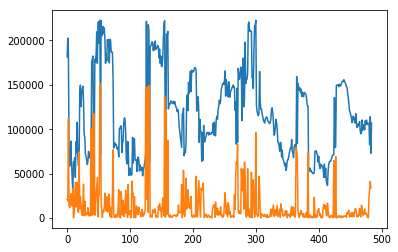

In [166]:
mergedAreas = np.array(mergedAreas)
diff = abs(mergedAreas[1:] - mergedAreas[:-1])
diff_median = statistics.median(diff)
diff_mean = sum(diff)/len(diff)

print(diff_median, diff_mean)

mergedAreas = np.array(mergedAreas)
plt.plot(mergedAreas)
plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]))
plt.show()

0.03117373144071945 0.08977847519499192


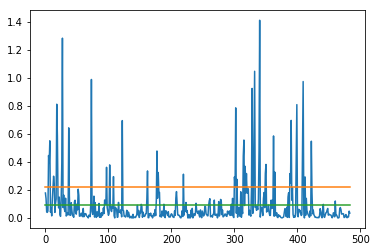

In [163]:
'''
개선방향
 - 차분값을 절대 면적 차이가 아니라 이전 면적에 대한 비로 해야함 [v]
 - 특이점에서 shrink_ratio 만큼 줄어들때 방향 고려하기 [v]
 - 맨처음, 맨 마지막 몇 프레임 제거하기 [v]
 - 디텍팅 영역 마진 조금 주기 [v]
 - 손, 팔 관련 처리가 사후로 한번 필요하긴 할듯...
'''
# 면적비 차분
mergedAreas = np.array(mergedAreas)
diff = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
diff_median = statistics.median(diff)
diff_mean = sum(diff)/len(diff)

print(diff_median, diff_mean)
plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:])
meds = [diff_median*7 for i in range(len(mergedAreas[:-1]))]
means = [diff_mean for i in range(len(mergedAreas[:-1]))]
plt.plot(meds)
plt.plot(means)
plt.show()

In [164]:
import cv2
import numpy as np

cap = cv2.VideoCapture(videoPath)
preRect = []
idx = 0
shrink_ratio = 0.05 #  abnormal 관측시 5%씩 증감
margin = 0.05 # 검출영역 마진
while(1):
    ret, frame = cap.read()
    if(ret):
        mergedRect = allData[idx]
        cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
        if bool(preRect):
#             diff_area = calcArea(mergedRect)-calcArea(preRect)
#             if diff_median*7 < abs(diff_area):
            diff_area = calcArea(mergedRect)-calcArea(preRect)
            if diff_median*7 < abs(diff_area)/calcArea(preRect): # 비율로 계산
                width = preRect[2]-preRect[0]
                heigth = preRect[3]-preRect[1]
                if diff_area>0: # 커지는 경우
                    cv2.putText(frame, 'abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                    x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                    y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                    x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, videoWidth)
                    y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, videoHeight) 
#                     x = max(preRect[0]-width*shrink_ratio, 0)
#                     y = max(preRect[1]-heigth*shrink_ratio, 0)
#                     x2 = min(preRect[2]+width*shrink_ratio, videoWidth)
#                     y2 = min(preRect[3]+heigth*shrink_ratio, videoHeight)                    
                else: # 작아지는 경우
                    cv2.putText(frame, 'abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    x = preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio
                    y = preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio
                    x2 = preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio
                    y2 = preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio
#                     x = preRect[0]+width*shrink_ratio
#                     y = preRect[1]+heigth*shrink_ratio
#                     x2 = preRect[2]-width*shrink_ratio
#                     y2 = preRect[3]-heigth*shrink_ratio                      
                mergedRect = (int(x), int(y), int(x2), int(y2))
        
        if idx>0: # 첫 프레임 무시
            preRect = mergedRect

            # 마진 넣기
            detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                            int(max(mergedRect[1]-heigth*margin/2, 0)),
                            int(min(mergedRect[2]+width*margin/2, videoWidth)),
                            int(min(mergedRect[3]+heigth*margin/2, videoHeight)) )
            cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)

        cv2.imshow('frame',frame)
        cv2.imwrite('./img/bottle_'+str(idx)+'.jpg', frame)

        k = cv2.waitKey(30) & 0xff 
        if k == 27: # esc
            break
            
    else: break
    idx += 1    
        
cap.release()
cv2.destroyAllWindows()        

In [117]:
cap.release()
cv2.destroyAllWindows()      